# Commit time series clustering

Idea: extract the commit series for each developer and cluster them. For example,
    
* A did 1 commit on day 0 and 1 commit on day 2
* B did 1 commit on day 0 and 2 commits on day 2
* C did 1 commit on day 3

Let AB, BC and AC be the distances in the resulting 2,3-D clustering visualization. Thus

```
AB < BC
AB < AC
```

In other words, A and B should be much closer than A and C or B and C.

The data mining can be performed using [src-d/gitbase](https://github.com/src-d/gitbase) quite easily;
we are using [src-d/hercules](https://github.com/src-d/hercules) data because it has already been extracted
for `experience`.

In [1]:
from labours import ProtobufReader

In [19]:
import os
repos = []
for root, dirs, files in os.walk("statistics_v9.2.0/"):
    if "statistics.pb" in files:
        reader = ProtobufReader()
        reader.read(os.path.join(root, "statistics.pb"))
        repos.append(reader.get_devs() + reader.get_header())

In [4]:
len(repos)

117

## Now we need to match the identities across 117 repositories

In [14]:
from networkx import connected_components, Graph

In [28]:
graph = Graph()
for people, _, _, _ in repos:
    for p in people:
        keys = p.split("|")
        for x in keys:
            for y in keys:
                if x < y:
                    graph.add_edge(x, y)
                elif x == y:
                    graph.add_node(x)  # this is important!

In [29]:
identities = []
for cc in connected_components(graph):
    identities.append("|".join(sorted(cc, key=lambda s: s if "@" not in s else "|" + s)))

In [30]:
len(identities)

2956

In [31]:
idmap = {}
for i, sig in enumerate(identities):
    for key in sig.split("|"):
        idmap[key] = i

### Collect the time series per identity

In [36]:
from collections import defaultdict
from datetime import datetime, timedelta

min_start_time = None
for _, _, start_time, _ in repos:
    if min_start_time is None or min_start_time > start_time:
        min_start_time = start_time
min_start_time = datetime.utcfromtimestamp(min_start_time)

data = defaultdict(lambda: defaultdict(list))
for people, days, start_time, _ in repos:
    people = {i: idmap[p.split("|", 1)[0]] for i, p in enumerate(people)}
    base_date = datetime.utcfromtimestamp(start_time)
    delta = (base_date - min_start_time).days
    for day, devs in days.items():
        date = (base_date + timedelta(days=day)).date()
        for dev, devday in devs.items():
            data[people[dev]][day + delta].append(devday)

In [37]:
maxday = max(max(v) for v in data.values())
maxday

11058

### We define the distance metric

For a pair of developer indexes `(d1, d2)` the following function returns the distance between the corresponding commit time series.

The actual measurement algorithm is Dynamic Time Warping, with "fast" linear-time refinement, which is as precise as `radius` is big.

In [162]:
from fastdtw import fastdtw
import numpy

def dtwdist(d1, d2):
    s1 = sorted((k, sum(d.Commits for d in v)) for k, v in data[d1].items())
    s2 = sorted((k, sum(d.Commits for d in v)) for k, v in data[d2].items())
    offset = min(s1[0][0], s2[0][0])
    maxday = max(s1[-1][0], s2[-1][0])
    arr1 = numpy.zeros(maxday - offset + 1, dtype=numpy.float32)
    arr2 = numpy.zeros_like(arr1)
    for d, v in s1:
        arr1[d - offset] = v
    for d, v in s2:
        arr2[d - offset] = v
    return fastdtw(arr1 / arr1.mean(), arr2 / arr2.mean(), radius=30, dist=1)[0]

### Calculate the pairwise distances matrix

In [163]:
datalist = sorted((k, v) for k, v in data.items()
                  if sum(sum(d.Commits for d in days) for days in v.values()) > 10)
from tqdm import tqdm

dists = numpy.zeros((len(datalist),) * 2)
for x, (d1, _) in tqdm(list(enumerate(datalist))):
    for y, (d2, _) in enumerate(datalist[x + 1:]):
        y += x + 1
        dists[x, y] = dists[y, x] = dtwdist(d1, d2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  

  0%|          | 0/318 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float6

100%|██████████| 318/318 [12:32<00:00,  2.37s/it]

In [164]:
dists

array([[   0.        ,  219.94733238, 1554.52470344, ..., 4833.21498489,
        6377.79744339, 1488.19057655],
       [ 219.94733238,    0.        , 1578.06654096, ..., 4231.41864014,
        6319.17100906, 1383.24324036],
       [1554.52470344, 1578.06654096,    0.        , ..., 4486.21039319,
        6326.55723405, 2422.47676396],
       ...,
       [4833.21498489, 4231.41864014, 4486.21039319, ...,    0.        ,
        4286.3331604 , 3757.1428299 ],
       [6377.79744339, 6319.17100906, 6326.55723405, ..., 4286.3331604 ,
           0.        , 4057.33335876],
       [1488.19057655, 1383.24324036, 2422.47676396, ..., 3757.1428299 ,
        4057.33335876,    0.        ]])

### Embed the elements (developers) based on the calculated distance matrix

Thus each developer becomes a 2-dimensional dense vector, and the resulting space should conform to our
intrisic requirement from the notebook header.

In [165]:
from umap import UMAP
embeddings = UMAP(metric="precomputed", n_neighbors=5).fit_transform(dists)

In [63]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


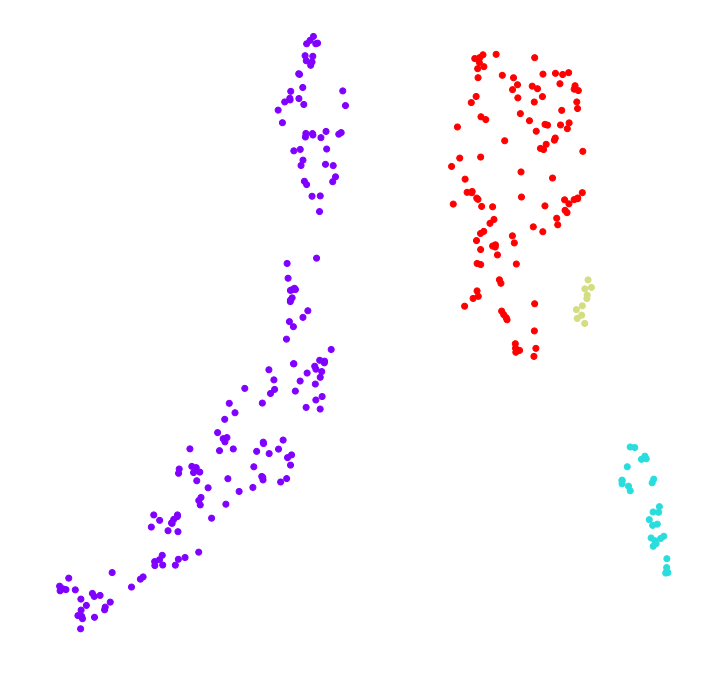

In [170]:
rcParams["figure.figsize"] = 12, 12
from hdbscan import HDBSCAN
clusters = HDBSCAN().fit_predict(embeddings)
scatter(embeddings[:, 0], embeddings[:, 1], c=clusters, cmap="rainbow")
_ = axis("off")

### Load the GitLab team mapping

In [84]:
!wget https://gitlab.com/gitlab-com/www-gitlab-com/raw/master/data/team.yml

--2019-03-28 23:18:58--  https://gitlab.com/gitlab-com/www-gitlab-com/raw/master/data/team.yml
Resolving gitlab.com (gitlab.com)... 35.231.145.151
Connecting to gitlab.com (gitlab.com)|35.231.145.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 635155 (620K) [text/plain]
Saving to: ‘team.yml’

team.yml            100%[===================>] 620.27K   950KB/s    in 0.7s    

2019-03-28 23:18:59 (950 KB/s) - ‘team.yml’ saved [635155/635155]



In [85]:
import yaml
with open("team.yml") as f:
    team = yaml.load(f)

In [97]:
departments = defaultdict(list)
failures = 0
for p in team:
    if p["type"] == "vacancy":
        continue
    try:
        x = idmap.get("%s@gitlab.com" % p["gitlab"])
        if x is None:
            x = idmap.get(p["gitlab"])
    except KeyError:
        pass
    if x is None:
        x = idmap.get(p["name"].lower())
    if x is None:
        failures += 1
        continue
    departments[p["departments"][-1]].append(x)
print(failures, len(team))

364 895


364 people are missing in our dataset :( Are they working on secret projects?

In [98]:
subdepartments = sorted((k, v) for k, v in departments.items() if len(v) < 20)
subdepmap = {}
for i, (k, v) in enumerate(subdepartments):
    for dev in v:
        if dev in subdepmap:
            print(k)
            subdepmap[dev] = -1  # fuzzy
        subdepmap[dev] = i

Sales
UX Department
UX Department


### See how GitLab employees map to the embedding space

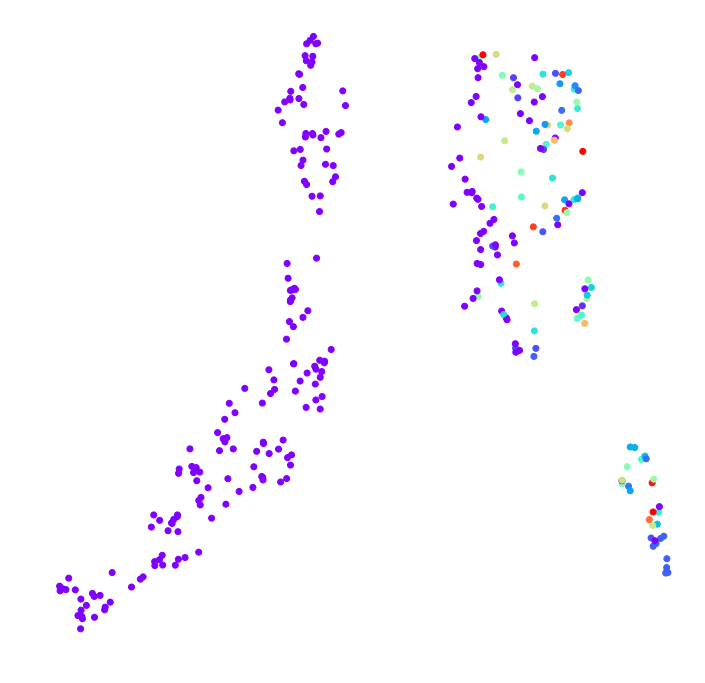

In [167]:
scatter(embeddings[:, 0], embeddings[:, 1], c=[subdepmap.get(d[0], -1) for d in datalist], cmap="rainbow")
_ = axis("off")

The result is promising, we have a clear distinction between external contributors and GitLab employees.

### Let's investigate the lower-right cluster

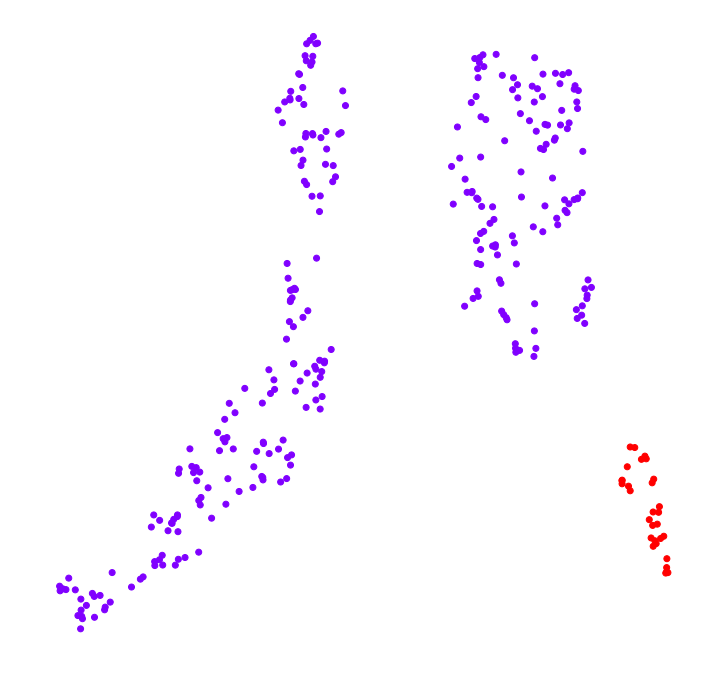

In [176]:
scatter(embeddings[:, 0], embeddings[:, 1], c=[(c if c == 1 else 0) for c in clusters], cmap="rainbow")
_ = axis("off")

### Here are the teams involved in that cluster

In [180]:
cluster1 = {i for i, c in enumerate(clusters) if c == 1}
sorted(subdepartments[subdepmap.get(d[0], -1)][0] for i, d in enumerate(datalist) if i in cluster1)

['Core Team',
 'Core Team Alumni',
 'Core Team Alumni',
 'Core Team Alumni',
 'Core Team Alumni',
 'Core Team Alumni',
 'Core Team Alumni',
 'Core Team Alumni',
 'Core Team Alumni',
 'Create BE Team',
 'Create BE Team',
 'Create FE Team',
 'Dev UX Team',
 'Distribution BE Team',
 'Distribution BE Team',
 'Engineering Function',
 'Engineering Function',
 'Gitaly Team',
 'Infrastructure Department',
 'Meltano',
 'Merge Request coach',
 'Monitor FE Team',
 'Plan BE Team',
 'Plan FE Team',
 'Serverless BE Team',
 'Verify FE Team',
 'Verify Team',
 'Verify Team',
 'Verify Team',
 'Verify Team']

### Here are the people

As we see, many "Core Team" members are together, good. I looked at their GitLab contribution charts and they are all tightly packed => this is in common. Besides, Dynamic Time Warping guarantees that they tend to commit simultaneously, within a short time period.

In [185]:
sorted((subdepartments[subdepmap[d[0]]][0], d[0], identities[d[0]])
       for i, d in enumerate(datalist)
       if i in cluster1 and d[0] in subdepmap)

[('Core Team',
  48,
  'rymai|rémy coutable|remy@gitlab.com|remy@rymai.me|🏖 rémy coutable 🏖'),
 ('Core Team Alumni',
  32,
  'ayufan|kamil trzcinski|kamil trzciński|kamil trzciński|kamil trzciński (ooo till 16th of april)|kamil trzciński (ooo till 3th)|ayufan@ayufan.eu|kamil.trzcinski@polidea.com|kamil@gitlab.com'),
 ('Core Team Alumni',
  34,
  'robert speicher|15139-rspeicher@users.noreply.gitlab.com|robert@gitlab.com|rspeicher@gmail.com'),
 ('Core Team Alumni',
  37,
  'stan hu|stanhu|stan@gitlab.com|stanhu@alum.mit.edu|stanhu@gmail.com|stanhu@packetzoom.com|stanhu@users.noreply.github.com'),
 ('Core Team Alumni',
  52,
  'devaroop|devaroop bhattacharya|gitlab|marin jankovski|devaroop123@yahoo.co.in|example@example.com|git@dv6700.(none)|gitlab@localhost|gitlab@micazook.com|gitlab@mikebajur.com|gitlab@stone-server1|marin@gitlab.com|marin@marins-macbook-pro.local|maxlazio@gmail.com|projects@quackenbush.me|root@gitlab.com'),
 ('Core Team Alumni',
  125,
  'dmitriy zaporozhets|dz|randx

### Where are the "Core Team" members?

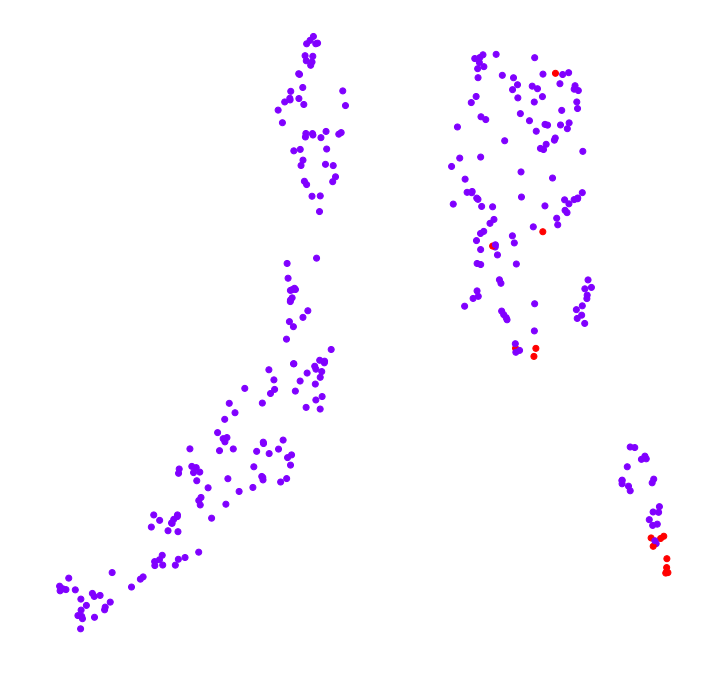

In [187]:
team_view = []
for d in datalist:
    dep = subdepmap.get(d[0], -1)
    if dep >= 0:
        team = subdepartments[dep][0]
        if "Core Team" in team:
            team_view.append(1)
            continue
    team_view.append(0)
scatter(embeddings[:, 0], embeddings[:, 1], c=team_view, cmap="rainbow")
_ = axis("off")

Almost everybody went to the cluster, good.

### Now the second cluster

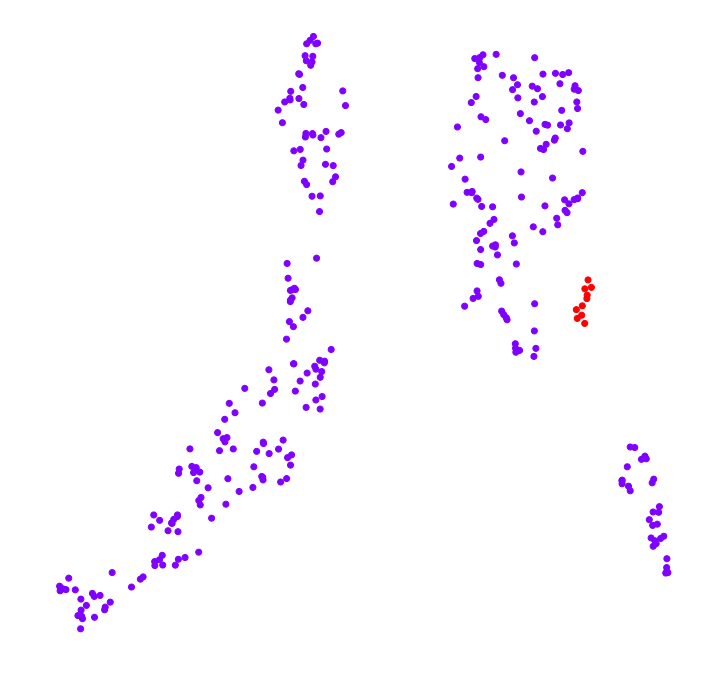

In [189]:
scatter(embeddings[:, 0], embeddings[:, 1], c=[(c if c == 2 else 0) for c in clusters], cmap="rainbow")
_ = axis("off")

In [193]:
cluster2 = {i for i, c in enumerate(clusters) if c == 2}
sorted(subdepartments[subdepmap.get(d[0], -1)][0] for i, d in enumerate(datalist) if i in cluster2)

['CI/CD UX Team',
 'Engineering Productivity Team',
 'Frontend',
 'Infrastructure Department',
 'Manage FE Team',
 'Monitor BE Team',
 'Ops UX Team',
 'Release BE Team',
 'Verify Team',
 'Verify Team']

In [194]:
sorted((subdepartments[subdepmap[d[0]]][0], d[0], identities[d[0]])
       for i, d in enumerate(datalist)
       if i in cluster2 and d[0] in subdepmap)

[('CI/CD UX Team',
  5,
  'dimitrie hoekstra|dimitrieh|dimitrie@gitlab.com|dimitriehoekstra@gmail.com'),
 ('Engineering Productivity Team',
  115,
  'mark fletcher|mark@gitlab.com|markglenfletcher@googlemail.com'),
 ('Frontend', 8, 'tim zallmann|tim@tpmgames.com|tzallmann@gitlab.com'),
 ('Infrastructure Department',
  343,
  'andrew newdigate|andrew@gitlab.com|andrew@troupe.co'),
 ('Manage FE Team',
  11,
  'luke "jared" bennett|luke bennett|jared@jareds-macbook-pro.local|lbennett@gitlab.com|lukeeeebennettplus@gmail.com'),
 ('Monitor BE Team', 42, 'ben kochie|bjk@gitlab.com|superq@gmail.com'),
 ('Ops UX Team', 18, 'taurie davis|tauriedavis|taurie@gitlab.com'),
 ('Release BE Team',
  269,
  'alessio caiazza|acaiazza@gitlab.com|alessio@chorally.com|nolith@abisso.org|nolith@users.noreply.github.com')]

### Finally, I generate 3D embeddings to show an interactive visualization (not included into the notebook)

We are going to use Tableau or something else.

In [188]:
embeddings3d = UMAP(metric="precomputed", n_neighbors=5, n_components=3).fit_transform(dists)

In [201]:
import csv
with open("commits.csv", "w") as fout:
    writer = csv.writer(fout)
    writer.writerow(["x", "y", "z", "name", "department", "commits", "activity_days"])
    for e, d in zip(embeddings3d, datalist):
        try:
            dep = subdepartments[subdepmap[d[0]]][0]
        except KeyError:
            dep = "undefined"
        name = identities[d[0]]
        ncommits = sum(sum(d.Commits for d in v) for k, v in d[1].items())
        activity_days = max(d[1]) - min(d[1])
        writer.writerow(list(e) + [name, dep, ncommits, activity_days])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  # This is added back by InteractiveShellApp.init_path()
